In [1]:
from pathlib import Path

import numpy as np
import ezmsg.core as ez
import matplotlib.pyplot as plt

from ezmsg.util.messages.axisarray import AxisArray
from ezmsg.util.terminate import TerminateOnTotal
from ezmsg.util.messagereplay import (
    MessageReplay, 
    MessageReplaySettings,
    MessageCollector
)

from ezmsg.ssvep.spectralstats import SpectralStats, SpectralStatsSettings

from typing import List, Any


In [2]:
class OfflineStatsSettings(ez.Settings):
    replay_settings: MessageReplaySettings
    stats_settings: SpectralStatsSettings


class OfflineStats(ez.Collection):
    SETTINGS: OfflineStatsSettings

    REPLAY = MessageReplay()
    STATS = SpectralStats()
    COLLECTOR = MessageCollector()
    TERM = TerminateOnTotal()

    def configure(self) -> None:
        self.REPLAY.apply_settings(self.SETTINGS.replay_settings)
        self.STATS.apply_settings(self.SETTINGS.stats_settings)

    def network(self) -> ez.NetworkDefinition:
        return (
            (self.REPLAY.OUTPUT_MESSAGE, self.STATS.INPUT_SAMPLE),
            (self.STATS.OUTPUT_STATS, self.COLLECTOR.INPUT_MESSAGE),
            (self.COLLECTOR.OUTPUT_MESSAGE, self.TERM.INPUT_MESSAGE),
            (self.REPLAY.OUTPUT_TOTAL, self.TERM.INPUT_TOTAL),
        )
    
    @property
    def output(self) -> List[Any]:
        return self.COLLECTOR.messages

2023-03-04 13:40:10.143 - pid: 60880 - TaskThread - INFO - ensure_running: Started SHMServer. PID:60924@127.0.0.1:25979
2023-03-04 13:40:10.221 - pid: 60880 - TaskThread - INFO - ensure_running: Started GraphServer. PID:60925@127.0.0.1:25978
2023-03-04 13:40:10.297 - pid: 60880 - TaskThread - INFO - update_stats: Insufficient number of observations
2023-03-04 13:40:10.851 - pid: 60880 - TaskThread - INFO - pub_messages: Replayed 20 messages from /Users/milsagw1/ssvep_data/SSVEP_S5/10Hz_20x_20230302T192618.txt
2023-03-04 13:40:11.034 - pid: 60880 - TaskThread - INFO - wrapped_task: OfflineStats/REPLAY:pub_messages Complete
2023-03-04 13:40:13.915 - pid: 60880 - TaskThread - INFO - wrapped_task: Normal Termination raised in OfflineStats/TERM:on_message
2023-03-04 13:40:13.918 - pid: 60880 - MainThread - INFO - run: All processes exited normally
2023-03-04 13:40:13.926 - pid: 60880 - TaskThread - INFO - _shutdown_servers: Terminating GraphServer
2023-03-04 13:40:13.935 - pid: 60880 - Task

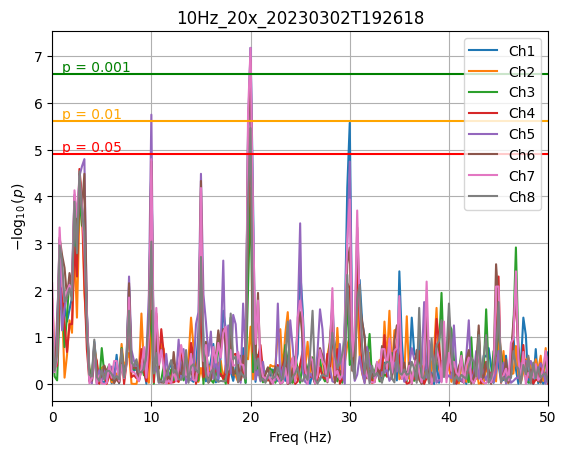

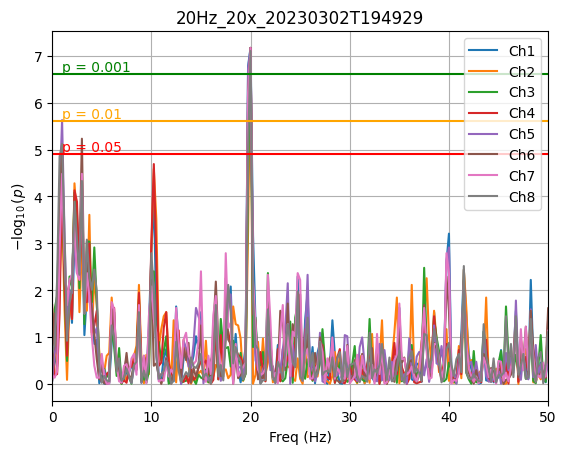

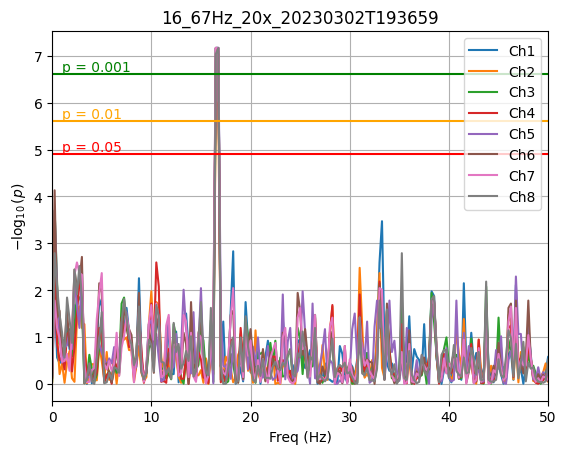

In [3]:
data_dir = Path.home() / 'ssvep_data'

for data_fname in (data_dir / 'SSVEP_S5').glob('*.txt'):

    settings = OfflineStatsSettings(
        replay_settings = MessageReplaySettings(
            filename = data_fname
        ),
        stats_settings = SpectralStatsSettings(
            time_axis = 'time',
            integration_time = 4.0,
            multiple_comparisons = False
        )
    )

    system = OfflineStats(settings)

    ez.run(system, force_single_process = True)

    stats: AxisArray = system.output[-1]
    freq_axis = 'freq'
    axis = stats.get_axis(freq_axis)
    axis_idx = stats.get_axis_idx(freq_axis)
    freqs = (np.arange(stats.shape[axis_idx]) * axis.gain) + axis.offset
    num_tests = np.prod(stats.shape)

    fig, ax = plt.subplots()
    with stats.view2d(freq_axis) as view:
        for ch in range(view.shape[1]):
            ax.plot(freqs, view[:, ch], label = f'Ch{ch+1}')

    for thresh, color in zip([0.05, 0.01, 0.001], ['red', 'orange', 'green']):
        xthresh = -np.log10(thresh / num_tests)
        ax.axhline(xthresh, color = color)
        ax.annotate(f'p = {thresh}', (1, xthresh), va = 'bottom', color = color)

    ax.legend()

    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel(r'$-\log_{10}(p)$')
    ax.grid(True, which = 'both')
    ax.set_xlim( 0, 50.0 )

    ax.set_title(data_fname.stem)
